<a href="https://colab.research.google.com/github/AppleBoiy/ocr-handwritten-digit/blob/main/notebooks/cnn/200epoch_VGG16_trf_higher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handwritten Digit Recognition with CNN
 Use Transfer Learning with a Pretrained Model (Opt for 200epoch)





## Step 1: Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

## Step 2: Load and Preprocess the Data


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


### Original Grayscale Images

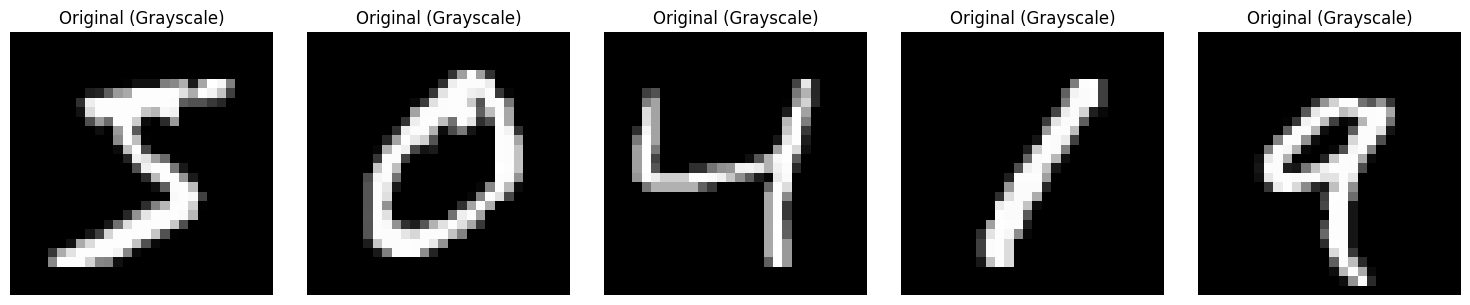

In [3]:
# Select a few samples to visualize
samples_to_visualize = 5
plt.figure(figsize=(15, 3))
for i in range(samples_to_visualize):
    plt.subplot(1, samples_to_visualize, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title('Original (Grayscale)')
    plt.axis('off')
plt.tight_layout()
plt.show()

### Convert Grayscale to RGB (Repeat Channels)

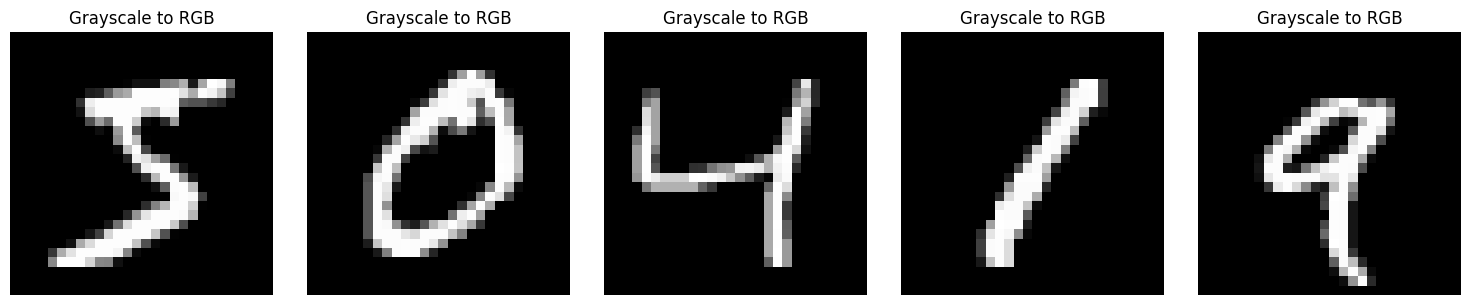

In [4]:
x_train_rgb = np.repeat(x_train[..., np.newaxis], 3, -1)  # Shape: (60000, 28, 28, 3)
x_test_rgb = np.repeat(x_test[..., np.newaxis], 3, -1)    # Shape: (10000, 28, 28, 3)

plt.figure(figsize=(15, 3))
for i in range(samples_to_visualize):
    plt.subplot(1, samples_to_visualize, i + 1)
    plt.imshow(x_train_rgb[i])
    plt.title('Grayscale to RGB')
    plt.axis('off')
plt.tight_layout()
plt.show()

### Resize to 32x32 (for VGG16)

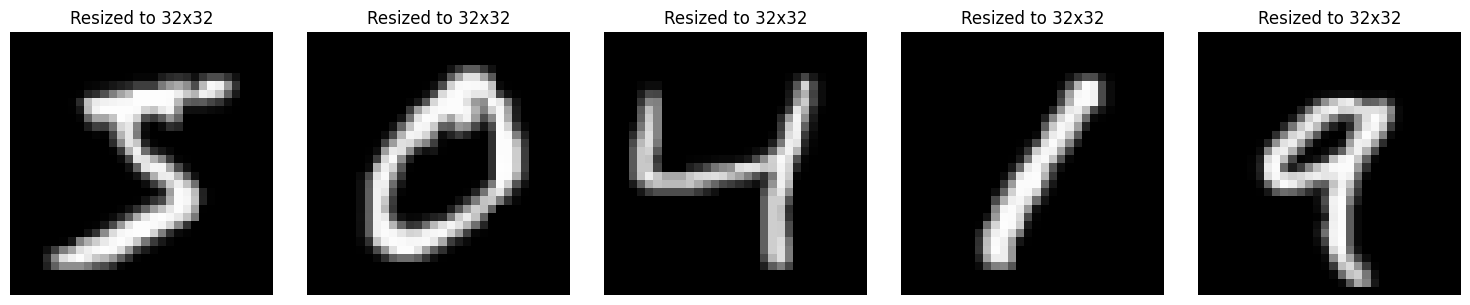

In [5]:
x_train_rgb_resized = tf.image.resize(x_train_rgb, (32, 32))
x_test_rgb_resized = tf.image.resize(x_test_rgb, (32, 32))

plt.figure(figsize=(15, 3))
for i in range(samples_to_visualize):
    plt.subplot(1, samples_to_visualize, i + 1)
    plt.imshow(x_train_rgb_resized[i].numpy().astype('uint8'))  # Convert tensor to uint8 for visualization
    plt.title('Resized to 32x32')
    plt.axis('off')
plt.tight_layout()
plt.show()

### Normalization (Pixel Values in Range [0, 1])

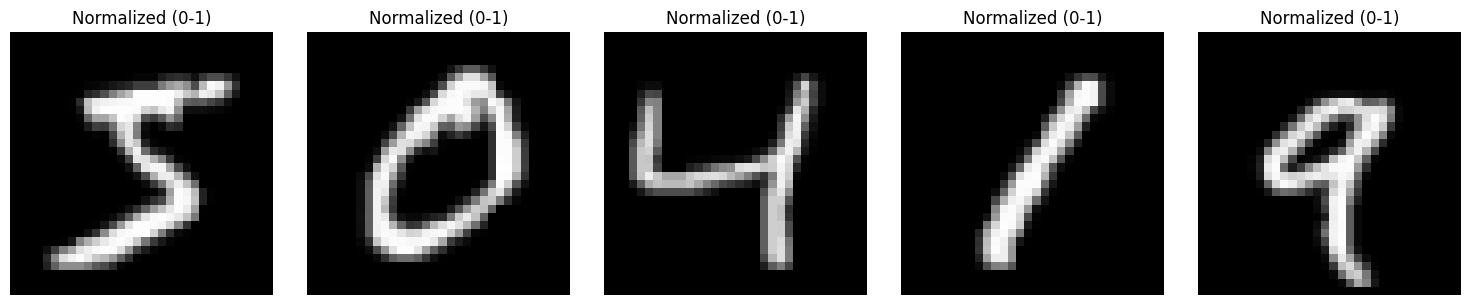

In [6]:
x_train_rgb_resized_normalized = x_train_rgb_resized / 255.0
x_test_rgb_resized_normalized = x_test_rgb_resized / 255.0

plt.figure(figsize=(15, 3))
for i in range(samples_to_visualize):
    plt.subplot(1, samples_to_visualize, i + 1)
    plt.imshow(x_train_rgb_resized_normalized[i].numpy())
    plt.title('Normalized (0-1)')
    plt.axis('off')
plt.tight_layout()
plt.show()

### Convert class vectors to binary class matrices (one-hot encoding)

In [7]:
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [8]:
# Check the shape of training and test data
print(f"Shape of x_train_rgb_resized_normalized: {x_train_rgb_resized_normalized.shape}")
print(f"Shape of x_test_rgb_resized_normalized: {x_test_rgb_resized_normalized.shape}")

Shape of x_train_rgb_resized_normalized: (60000, 32, 32, 3)
Shape of x_test_rgb_resized_normalized: (10000, 32, 32, 3)


## Step 3: Data Augmentation


In [9]:
x_train_rgb_resized_normalized = x_train_rgb_resized_normalized.numpy()  # Convert to NumPy array
x_test_rgb_resized_normalized = x_test_rgb_resized_normalized.numpy()  # Convert to NumPy array

In [10]:
x_train_rgb, x_val_rgb, y_train, y_val = train_test_split(
    x_train_rgb_resized_normalized, y_train, test_size=0.2, random_state=42
)


In [11]:
print(f"Shape of x_train_rgb: {x_train_rgb.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of x_val_rgb: {x_val_rgb.shape}")
print(f"Shape of y_val: {y_val.shape}")

Shape of x_train_rgb: (48000, 32, 32, 3)
Shape of y_train: (48000, 10)
Shape of x_val_rgb: (12000, 32, 32, 3)
Shape of y_val: (12000, 10)


In [12]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

## Step 4: Build the CNN Model


In [13]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
base_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

In [15]:
model = models.Sequential([
    base_model,  # Pretrained base
    layers.Flatten(),  # Flatten the output of the base model
    layers.Dense(256, activation='relu'),  # Fully connected layer
    layers.Dropout(0.5),  # Add dropout for regularization
    layers.Dense(10, activation='softmax')  # Output layer for 10 classes
])

## Step 5: Compile the Model



In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Step 6: Train the Model

In [17]:
# Callbacks
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)


In [18]:
history = model.fit(datagen.flow(x_train_rgb, y_train, batch_size=256),
                    epochs=200,
                    validation_data=(x_val_rgb, y_val),
                    callbacks=[checkpoint, early_stopping, lr_schedule],
                    verbose=1)


Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


188/188 ━━━━━━━━━━━━━━━━━━━━ 52s 212ms/step - accuracy: 0.2447 - loss: 2.1517 - val_accuracy: 0.7303 - val_loss: 1.2744 - learning_rate: 1.0000e-04
Epoch 2/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - accuracy: 0.6123 - loss: 1.2979 - val_accuracy: 0.7849 - val_loss: 0.9076 - learning_rate: 1.0000e-04
Epoch 3/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 39s 185ms/step - accuracy: 0.7034 - loss: 0.9954 - val_accuracy: 0.8152 - val_loss: 0.7274 - learning_rate: 1.0000e-04
Epoch 4/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 35s 180ms/step - accuracy: 0.7509 - loss: 0.8351 - val_accuracy: 0.8403 - val_loss: 0.6188 - learning_rate: 1.0000e-04
Epoch 5/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 35s 177ms/step - accuracy: 0.7843 - loss: 0.7311 - val_accuracy: 0.8567 - val_loss: 0.5423 - learning_rate: 1.0000e-04
Epoch 6/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 36s 187ms/step - accuracy: 0.8077 - loss: 0.6533 - val_accuracy: 0.8705 - val_loss: 0.4822 - learning_rate: 1.0000e-04
Epoch 7/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 40s 183ms/s

## Step 7: Evaluate the Model


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


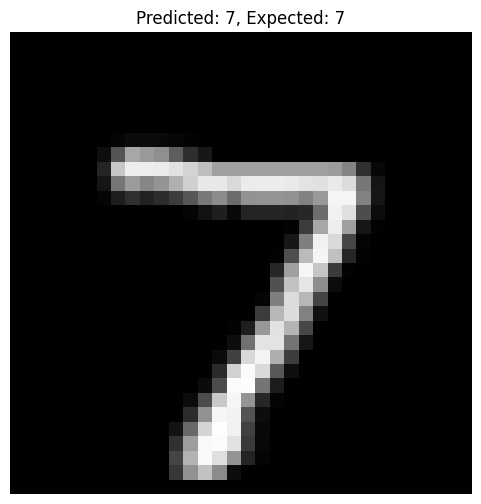

In [21]:
x_test_rgb_resized = tf.image.resize(x_test_rgb, (32, 32)).numpy()  # Resize to (32, 32)
x_test_rgb_resized_normalized = x_test_rgb_resized / 255.0  # Normalize the pixel values

predictions = model.predict(x_test_rgb_resized_normalized)

# Choose an index to display
index = 0

# Get the image, true label, and predicted label
test_image = x_test_rgb_resized_normalized[index]
true_label = y_test[index].argmax()
predicted_label = predictions[index].argmax()

plt.figure(figsize=(6, 6))
plt.imshow(test_image)
plt.title(f'Predicted: {predicted_label}, Expected: {true_label}')
plt.axis('off')
plt.show()

## Step 8: Visualize Predictions


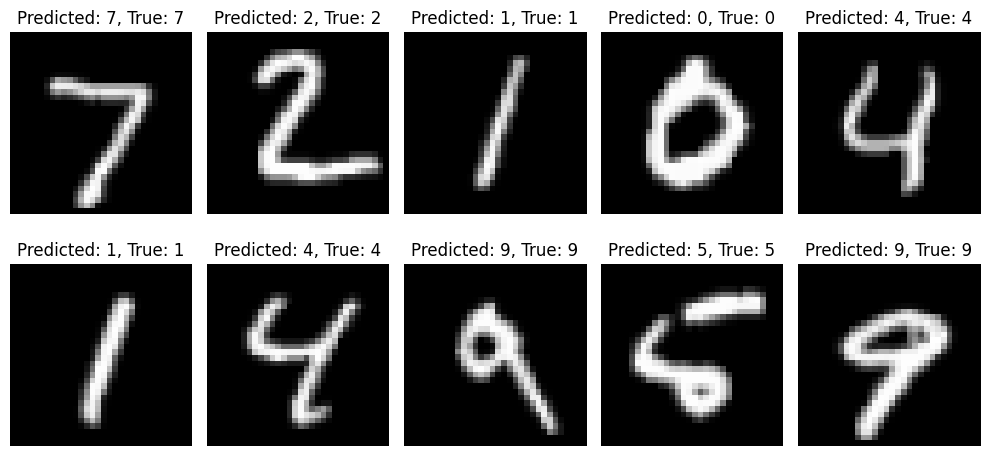

In [22]:
# Visualize some predictions
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test_rgb_resized_normalized[i])
    plt.title(f'Predicted: {predictions[i].argmax()}, True: {y_test[i].argmax()}')
    plt.axis('off')
plt.tight_layout()
plt.show()


## Step 9: Report Statistics


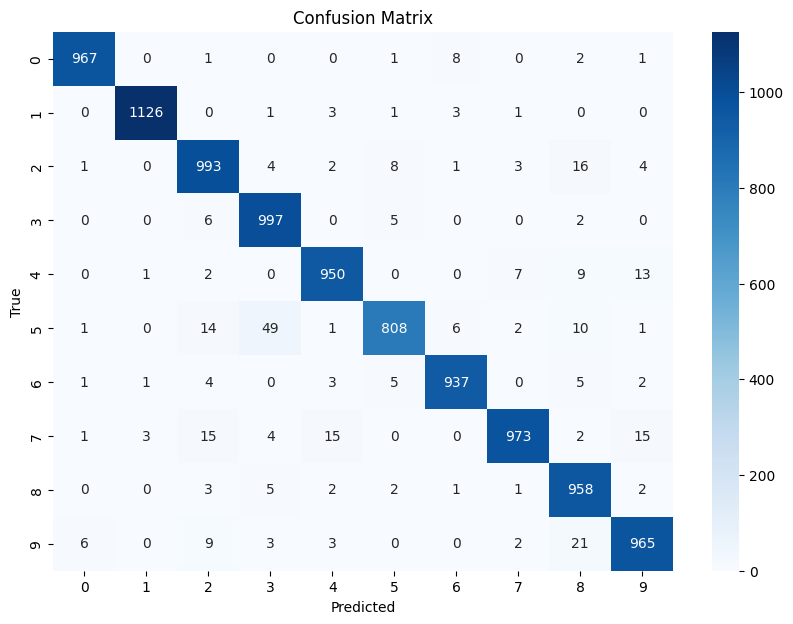

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.95      0.96      0.96      1032
           3       0.94      0.99      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.97      0.91      0.94       892
           6       0.98      0.98      0.98       958
           7       0.98      0.95      0.96      1028
           8       0.93      0.98      0.96       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [23]:

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Convert predictions and true labels from one-hot encoding
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate precision, recall, and F1-score
report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(10)])
print(report)

In [24]:
model.save('last.keras')
